![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 09. <i>Metody głębokiego uczenia (1)</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższym materiale zobaczymy w jaki sposób korzystać z metod głębokiego uczenia sieci neuronowych w pakiecie OpenCV.

Na początku załadujmy niezbędne biblioteki:

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

OpenCV wspiera [wiele](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV) bibliotek i modeli sieci neuronowych. Modele trenuje się poza OpenCV - bibliotekę wykorzystuje się tylko do predykcji, aczkolwiek sama w sobie ma całkiem sporo możliwych optymalizacji w porównaniu do źródłowych bibliotek neuronowych, więc predykcja może być tutaj faktycznie szybsza.

Pliki z modelami i danymi pomocniczymi będziemy pobierali z sieci i będziemy je zapisywali w katalogu `dnn`:

In [2]:
!mkdir -p dnn

# Klasyfikacja obrazów

Spróbujemy wykorzystać sieć do klasyfikacji obrazów wyuczonej na zbiorze [ImageNet](https://www.image-net.org/). Pobierzmy plik zawierający opis 1000 możliwych klas:

In [3]:
!wget -q --show-progress -O dnn/classification_classes_ILSVRC2012.txt https://raw.githubusercontent.com/opencv/opencv/master/samples/data/dnn/classification_classes_ILSVRC2012.txt 

dnn/classification_ 100%[===================>]  21,17K  --.-KB/s     w 0,005s  


Spójrzmy na pierwsze pięć klas w pliku:

In [4]:
with open('dnn/classification_classes_ILSVRC2012.txt', 'r') as f_fd:
    classes = f_fd.read().splitlines()
    
print(len(classes), classes[:5])

1000 ['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


Do klasyfikacji użyjemy sieci [DenseNet](https://arxiv.org/abs/1608.06993). Pobierzemy jedną z mniejszych [reimplementacji](https://github.com/shicai/DenseNet-Caffe), która jest hostowana m.in. na Google Drive (musimy doinstalować jeden pakiet):

In [5]:
!pip3 install --user --disable-pip-version-check gdown

In [6]:
import gdown

url = 'https://drive.google.com/uc?id=0B7ubpZO7HnlCcHlfNmJkU2VPelE'
output = 'dnn/DenseNet_121.caffemodel'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7ubpZO7HnlCcHlfNmJkU2VPelE
To: /home/andrzej/Pulpit/Notatki_magisterka/Widzenie komputerowe/aitech-wko-pub/dnn/DenseNet_121.caffemodel
100%|███████████████████████████████████████| 32.3M/32.3M [00:55<00:00, 587kB/s]


'dnn/DenseNet_121.caffemodel'

In [7]:
!wget -q --show-progress -O dnn/DenseNet_121.prototxt https://raw.githubusercontent.com/shicai/DenseNet-Caffe/master/DenseNet_121.prototxt

dnn/DenseNet_121.pr 100%[===================>]  74,68K  --.-KB/s     w 0,1s    


Konkretne biblioteki neuronowe posiadają dedykowane funkcje do ładowania modeli, np. [`readNetFromCaffe()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga29d0ea5e52b1d1a6c2681e3f7d68473a) lub [`readNetFromTorch()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga65a1da76cb7d6852bdf7abbd96f19084), jednak można też użyć ogólnej [`readNet()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422):

In [8]:
model = cv.dnn.readNet(model='dnn/DenseNet_121.prototxt', config='dnn/DenseNet_121.caffemodel', framework='Caffe')

Spróbujemy sklasyfikować poniższy obraz:

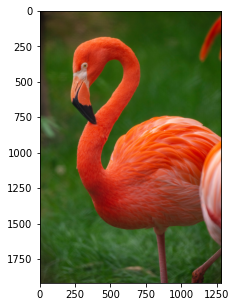

In [9]:
image = cv.imread('img/flamingo.jpg')
plt.figure(figsize=[5,5])
plt.imshow(image[:,:,::-1]);

Aby móc przepuścić obraz przez sieć musimy zmienić jego formę reprezentacji poprzez funkcję [`blobFromImage()`](https://docs.opencv.org/4.5.3/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7). Aby uzyskać sensowne dane musimy ustawić parametry dotyczące preprocessingu (informacje o tym są zawarte na [stronie modelu](https://github.com/shicai/DenseNet-Caffe)):

In [10]:
image_blob = cv.dnn.blobFromImage(image=image, scalefactor=0.017, size=(224, 224), mean=(104, 117, 123), 
                                  swapRB=False, crop=False)

Ustawiamy dane wejściowe w naszej sieci i pobieramy obliczone wartości:

In [11]:
model.setInput(image_blob)
outputs = model.forward()[0]

Wyliczamy która klasa jest najbardziej prawdopodobna:

In [12]:
outputs = outputs.reshape(1000, 1)

label_id = np.argmax(outputs)

probs = np.exp(outputs) / np.sum(np.exp(outputs))

Wynik:

99.99 %


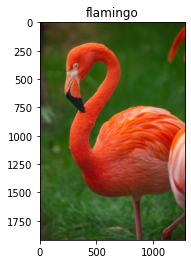

In [13]:
plt.imshow(image[:,:,::-1])
plt.title(classes[label_id])
print("{:.2f} %".format(np.max(probs) * 100.0))

# Wykrywanie twarzy

Do wykrywania twarzy użyjemy sieci bazującej na [SSD](https://github.com/weiliu89/caffe/tree/ssd):

In [14]:
!wget -q --show-progress -O dnn/res10_300x300_ssd_iter_140000_fp16.caffemodel https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel
!wget -q --show-progress -O dnn/res10_300x300_ssd_iter_140000_fp16.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

dnn/res10_300x300_s 100%[===================>]   5,10M   801KB/s     w 6,4s    
dnn/res10_300x300_s 100%[===================>]  27,45K  --.-KB/s     w 0,02s   


Ładujemy model:

In [15]:
model = cv.dnn.readNet(model='dnn/res10_300x300_ssd_iter_140000_fp16.prototxt', config='dnn/res10_300x300_ssd_iter_140000_fp16.caffemodel', framework='Caffe')

Będziemy chcieli wykryć twarze na poniższym obrazie:

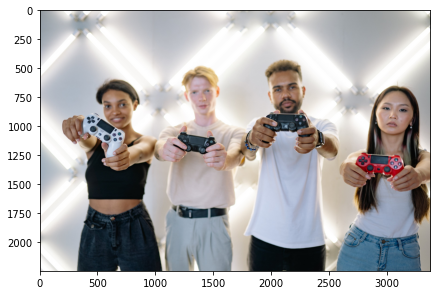

In [16]:
image = cv.imread('img/people.jpg')
plt.figure(figsize=[7,7])
plt.imshow(image[:,:,::-1]);

Znajdujemy twarze i oznaczamy je na zdjęciu (za próg przyjęliśmy 0.5; zob. informacje o [preprocessingu](https://github.com/opencv/opencv/tree/master/samples/dnn#face-detection)):

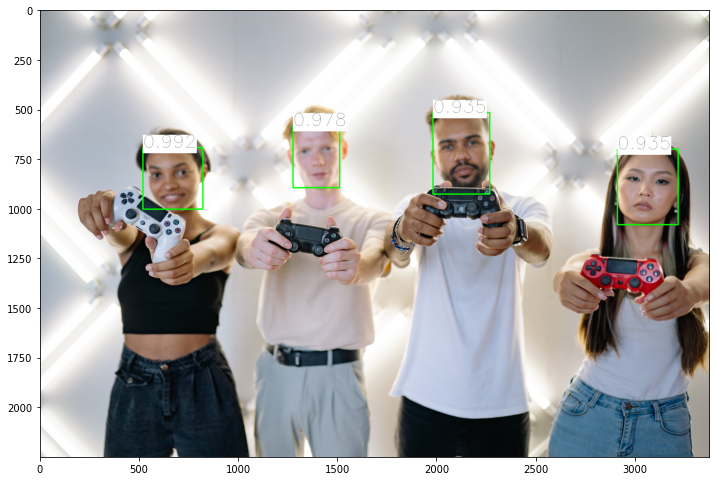

In [19]:
height, width, _ = image.shape

image_blob = cv.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=[104, 177, 123], 
                                  swapRB=False, crop=False)

model.setInput(image_blob)

detections = model.forward()

image_out = image.copy()

for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:

        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (x1, y1, x2, y2) = box.astype('int')

        cv.rectangle(image_out, (x1, y1), (x2, y2), (0, 255, 0), 6)
        label = '{:.3f}'.format(confidence)
        label_size, base_line = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 3.0, 1)
        cv.rectangle(image_out, (x1, y1 - label_size[1]), (x1 + label_size[0], y1 + base_line), 
                      (255, 255, 255), cv.FILLED)
        cv.putText(image_out, label, (x1, y1), cv.FONT_HERSHEY_SIMPLEX, 3.0, (0, 0, 0))
        
plt.figure(figsize=[12,12])
plt.imshow(image_out[:,:,::-1]);

## Punkty charakterystyczne twarzy

W OpenCV jest możliwość wykrywania punktów charakterystycznych twarzy (ang. *facial landmarks*). Użyjemy zaimplementowanego [modelu](http://www.jiansun.org/papers/CVPR14_FaceAlignment.pdf) podczas Google Summer of Code przy użyciu [`createFacemarkLBF()`](https://docs.opencv.org/4.5.3/d4/d48/namespacecv_1_1face.html#a0bec73a729ed878430c2feb9ce65bc2a):

In [20]:
!wget -q --show-progress -O dnn/lbfmodel.yaml https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml

dnn/lbfmodel.yaml   100%[===================>]  53,76M   852KB/s     w 73s     


In [21]:
landmark_detector = cv.face.createFacemarkLBF()
landmark_detector.loadModel('dnn/lbfmodel.yaml')

Ograniczamy nasze poszukiwania do twarzy:

In [22]:
faces = []

for detection in detections[0][0]:
    if detection[2] >= 0.5:
        left   = detection[3] * width
        top    = detection[4] * height
        right  = detection[5] * width
        bottom = detection[6] * height

        face_w = right - left
        face_h = bottom - top

        face_roi = (left, top, face_w, face_h)
        faces.append(face_roi)

faces = np.array(faces).astype(int)

_, landmarks_list = landmark_detector.fit(image, faces)

Model generuje 68 punktów charakterycznych, które możemy zwizualizować:

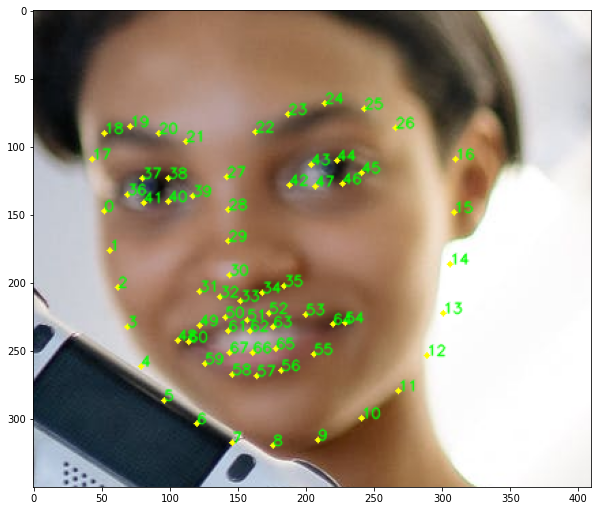

In [23]:
image_display = image.copy()
landmarks = landmarks_list[0][0].astype(int)

for idx, landmark in enumerate(landmarks):
    cv.circle(image_display, landmark, 2, (0,255,255), -1)
    cv.putText(image_display, str(idx), landmark, cv.FONT_HERSHEY_SIMPLEX, 0.35, (0, 255, 0), 1, 
                cv.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(image_display[700:1050,500:910,::-1]);

Jeśli nie potrzebujemy numeracji, to możemy użyć prostszego podejścia, tj. funkcji [`drawFacemarks()`](https://docs.opencv.org/4.5.3/db/d7c/group__face.html#ga318d9669d5ed4dfc6ab9fae2715310f5):

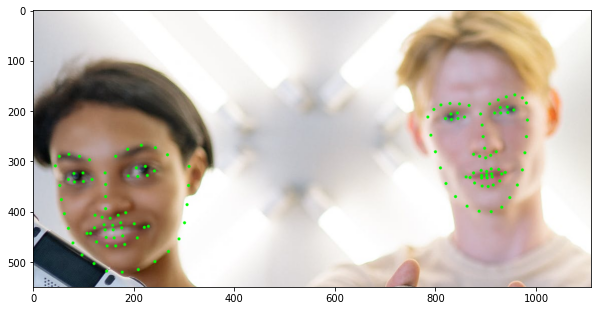

In [24]:
image_display = image.copy()
for landmarks_set in landmarks_list:
    cv.face.drawFacemarks(image_display, landmarks_set, (0, 255, 0))

plt.figure(figsize=(10,10))
plt.imshow(image_display[500:1050,500:1610,::-1]);

# Zadanie 1

W katalogu `vid` znajdują się filmy `blinking-*.mp4`. Napisz program do wykrywania mrugnięć. Opcjonalnie możesz użyć *eye aspect ratio* z [tego artykułu](http://vision.fe.uni-lj.si/cvww2016/proceedings/papers/05.pdf) lub zaproponować własne rozwiązanie.

/tmp/ipykernel_23191/4001600823.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,11))


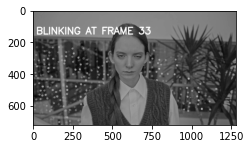

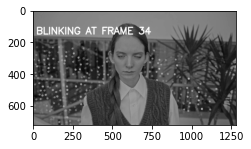

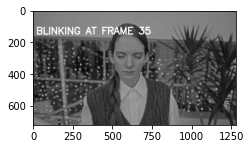

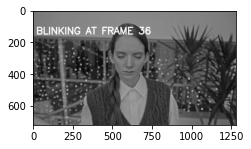

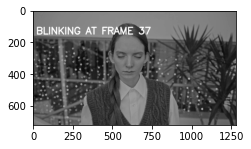

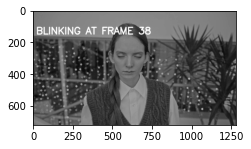

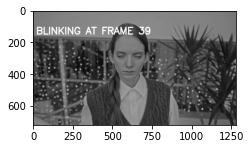

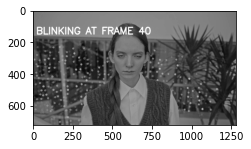

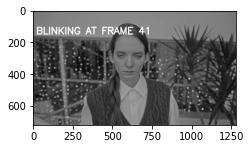

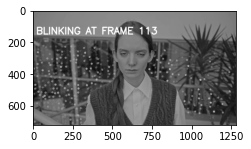

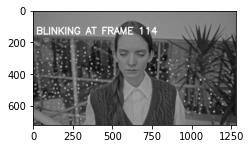

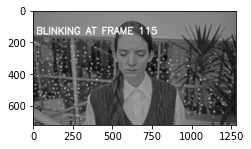

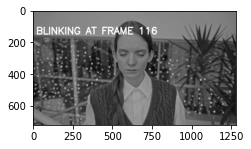

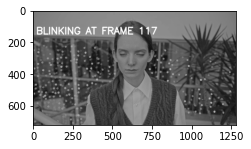

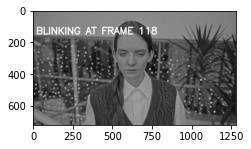

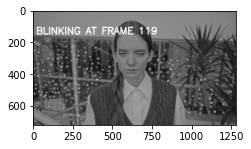

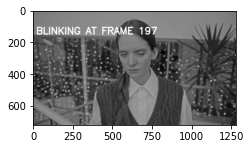

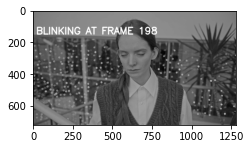

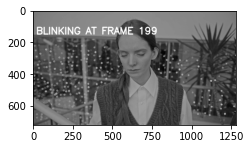

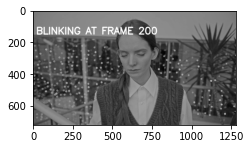

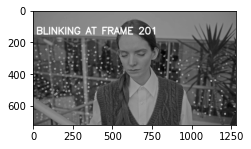

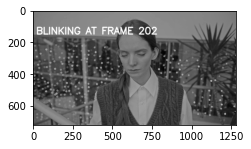

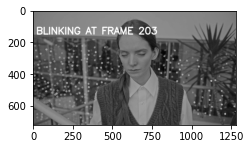

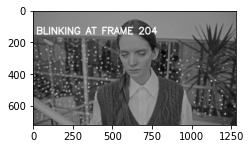

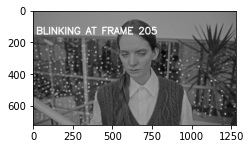

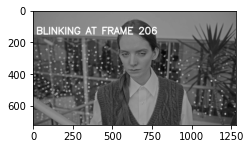

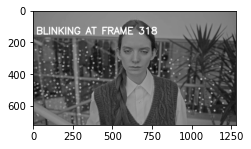

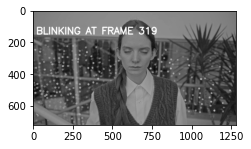

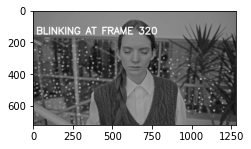

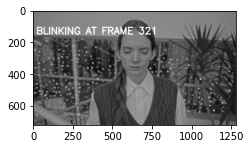

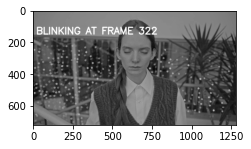

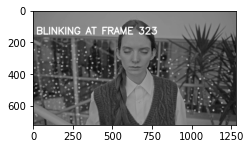

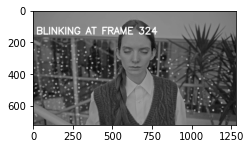

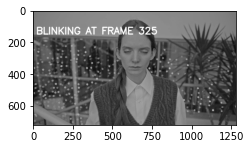

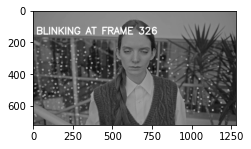

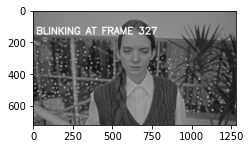

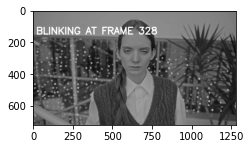

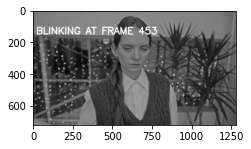

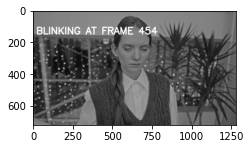

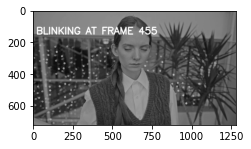

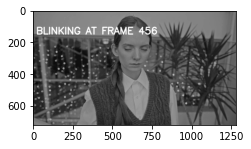

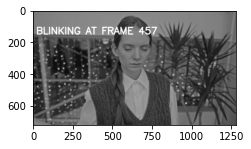

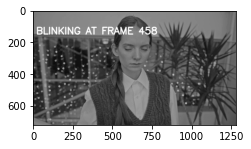

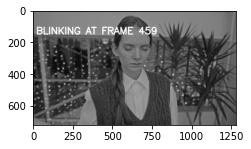

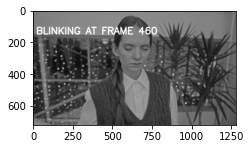

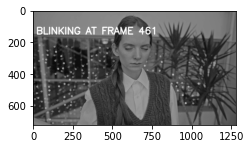

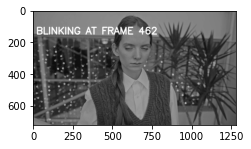

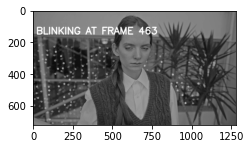

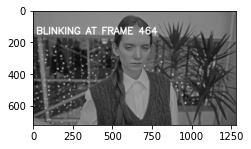

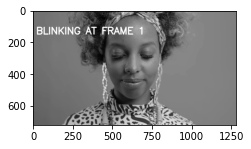

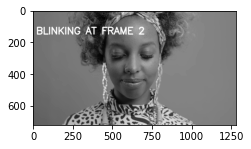

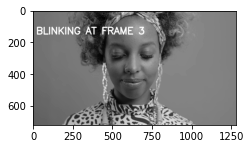

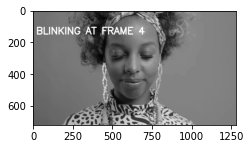

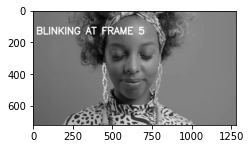

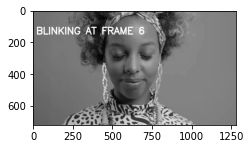

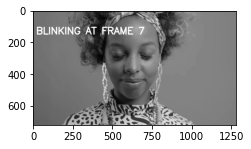

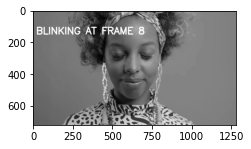

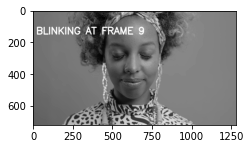

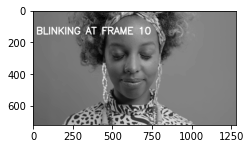

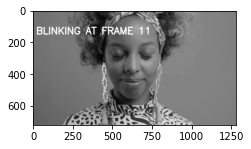

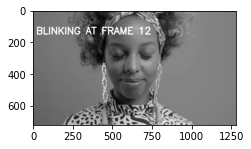

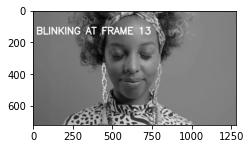

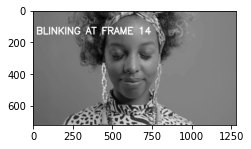

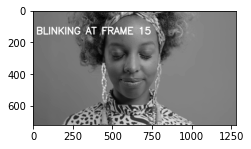

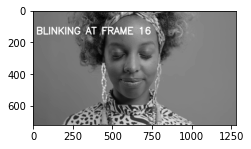

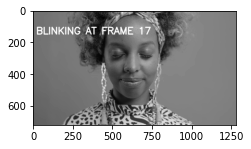

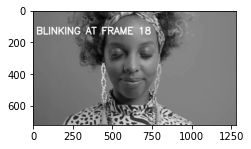

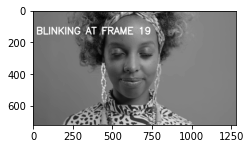

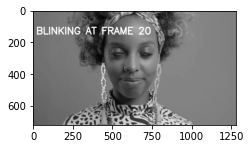

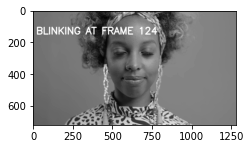

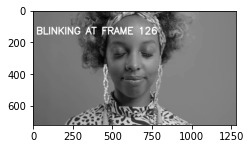

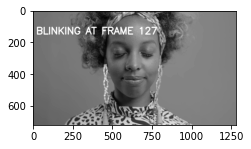

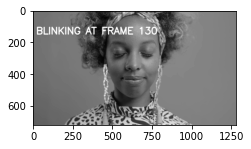

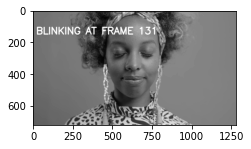

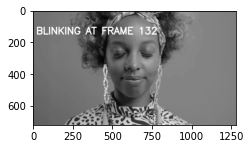

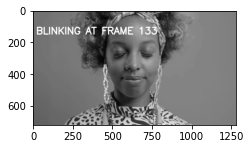

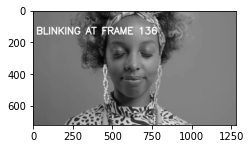

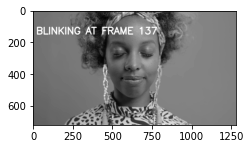

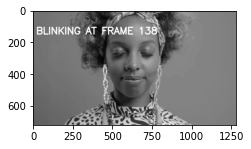

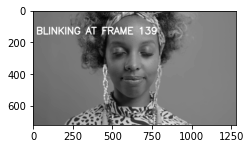

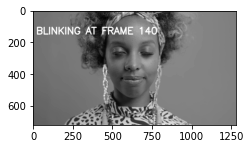

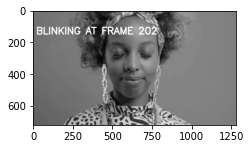

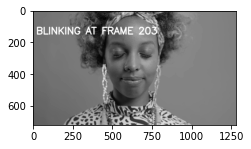

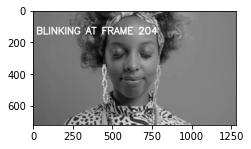

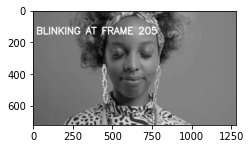

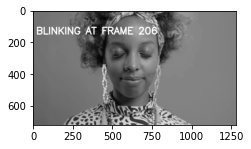

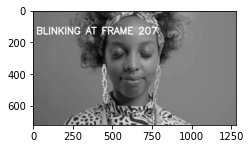

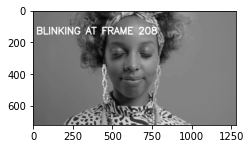

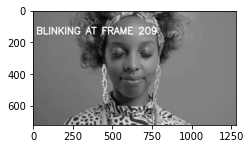

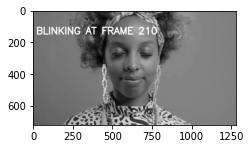

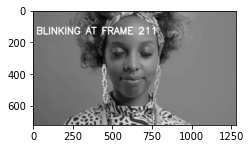

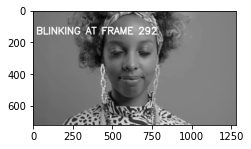

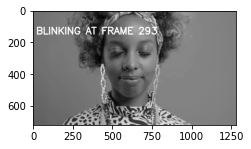

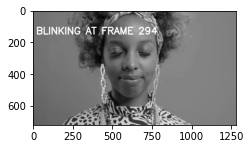

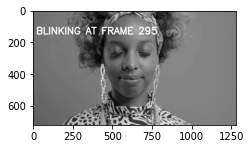

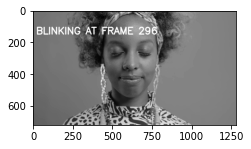

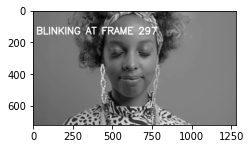

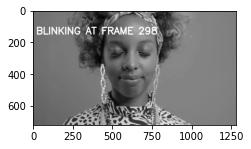

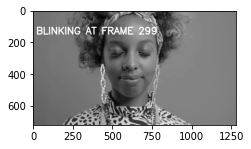

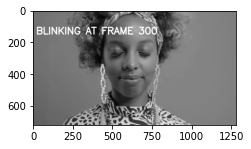

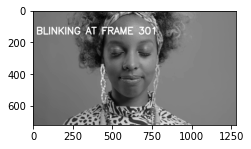

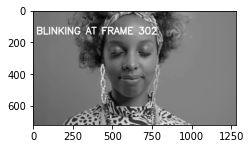

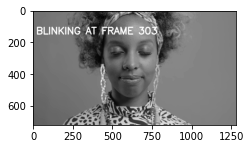

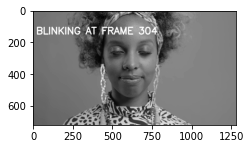

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import ipywidgets
import os
import random
import math
import dlib


THRESHOLD = 4.5

left_eye_landmarks = [36, 37, 38, 39, 40, 41]
right_eye_landmarks = [42, 43, 44, 45, 46, 47]

path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path)

def midpoint(point1, point2):
    return (point1.x + point2.x) / 2, (point1.y + point2.y) / 2


def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def get_blink_ratio(points, facial_landmarks):
    eye_left = (facial_landmarks.part(points[0]).x,
                   facial_landmarks.part(points[0]).y)
    eye_right = (facial_landmarks.part(points[3]).x,
                    facial_landmarks.part(points[3]).y)

    eye_top = midpoint(facial_landmarks.part(points[1]),
                          facial_landmarks.part(points[2]))
    eye_bottom = midpoint(facial_landmarks.part(points[5]),
                             facial_landmarks.part(points[4]))

    horizontal_length = euclidean_distance(eye_left, eye_right)
    vertical_length = euclidean_distance(eye_top, eye_bottom)

    ratio = horizontal_length / vertical_length

    return ratio


def detect_blinks(filename):
    i = 1
    cap = cv.VideoCapture(filename)
    while True:
        retval, frame = cap.read()

        if not retval:
            break

        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        faces, _, _ = detector.run(image=frame, upsample_num_times=0, adjust_threshold=0.0)

        for face in faces:

            landmarks = predictor(frame, face)

            left_eye_ratio = get_blink_ratio(left_eye_landmarks, landmarks)
            right_eye_ratio = get_blink_ratio(right_eye_landmarks, landmarks)
            blink_ratio = (left_eye_ratio + right_eye_ratio) / 2

            if blink_ratio > THRESHOLD:
                cv.putText(frame, f"BLINKING AT FRAME {i}", (20, 150), cv.FONT_HERSHEY_SIMPLEX,
                            2, (255, 0, 0), 6, cv.LINE_AA)

                plt.figure(figsize=(8,11))
                plt.subplot(221)
                plt.imshow(frame, cmap='gray')        
        i += 1
        
detect_blinks("vid/blinking-woman1.mp4")
detect_blinks("vid/blinking-woman2.mp4")